Recommendation System
===========

Doc2vec + Wide & Deep 을 이용한 추천시스템
----------------------------------

<div style="text-align:right"><h3>
AgileSoda | 2017.09.08.
</h3></div>

---

### 순서

1. 데이터 소개
2. Item2Vec
3. Item category
4. User Features
5. Data concate

---

본 문서에 사용된 데이터는 L.point 2016년 공모전에서 제공받은 데이터임을 밝힙니다.

---

# 데이터 소개

데이터의 행은 고객의 전체 거래상품들이 아니라 한 영수증(한 번 결제)상에 거래된 상품목록입니다. (이하 Session 이라고 표현)

해당 데이터가 꽤 크므로 간단한 분석용으로 줄였습니다.  
* C 제휴사 거래내역
* 고객별로 최대 10건의 거래내역 

각 데이터는 <U>`Agile_data.Lpoint_data_auoto_download`</U> 함수로 다운받으실 수 있습니다.

In [8]:
import sys
sys.version

'3.6.7 | packaged by conda-forge | (default, Feb 28 2019, 09:07:38) \n[GCC 7.3.0]'

In [2]:
import copy as cp
import pandas as pd , re , os
import time , numpy as np
import Agile_data
from IPython.display import Image
from multiprocessing import Pool
from gensim.models import doc2vec
from collections import namedtuple
import multiprocessing

## Data DownLoad

In [10]:
Agile_data.Lpoint_data_auoto_download()

데이터가 이미 다운로드 되어있습니다..


# Wide
* wide 모델은 sparse 하고 crosseed feature column 들의 다양한 집합의 선형 모델이다:
## Doc2vec , CrossCol

# Deep
* deep 모델은 feed-forward 신경망이다. 각각의 sparse, high-dimensional(고차원의) categorical feature 들은 종종 embedding 벡터라 불리는 low-dimensional(저차원의), dense real-valued 벡터로 변환된다. 이 low-dimensional(저차원의) dense embedding 벡터들은 continuouse feature 들로 연계되어 변환되고, 계속해서 다음 신경망의 hidden layers 로 연결된다
## train_categorical , train_continuous 합치기
## train_Segment 
## Doc2vec

> 같은 변수라도 wide : sparse / deep : embedding으로 넣을 수 있음

> 현재 형태
* wide : doc2vec + crosscol
* deep : doc2vec + continuous + Segment + Categorical

> 지금 만드는 형태 

* wide : crosscol + **Segment** + **Categorical** (doc2vec 빠진 형태)
* deep : doc2vec + continuous + Categorical(**embedding**) 

    * Q : doc2vec에 wide 쪽에 있어야하는 건지? -> 일단 넣어놓음
    * Q : Segment(**embedding**) 해야 할지?
        * 성별 하듯이 하면 좋을 듯? -> DEEP에 일단 넣지 않은 상황
    
> tf.decode_csv 형태로 만들기 위한 구조
* doc2vec , train_categorical + train_continuous + traing_segment ?

In [11]:
train_data, train_categorical, train_continuous, \
train_Segment, train_label = Agile_data.load_train_data()

In [12]:
test_data, test_categorical, test_continuous, test_Segment, \
test_label, test_label_eval = Agile_data.load_test_data()

---

Wide & Deep Model의 구조는 다음과 같습니다.  모형에 Input으로 들어가는 데이터는  
__ Item, Item_Categoty, User_Features __ 총 3개의 데이터입니다.

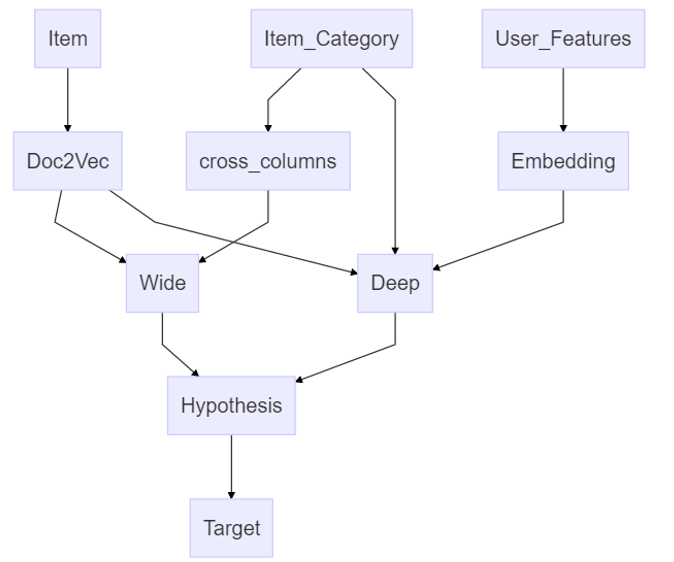

In [7]:
Image('images/Architecture.PNG')

---

## 2. Item2Vec

Item은 __구매했다. 안했다__의 바이너리 데이터입니다.  

고객/상품 | 상 품 종 류 가 .... 900개 정도
----------|--------------------------------------
ID:1      | 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 ... 0 0 0  0 0  

하지만 이렇게 0과 1로 조합된 고객의 Feature Vector는 상품의 수가 많을수록, 구매한 상품이 적을수록 sparse하므로 추가적인 무언가가 필요해 보입니다.  

여기서 NLP기술인 Doc2Vec을 사용해서 __Word Embedding -> Item Embedding__을 할 것입니다.  

고객이 구매했던 아이템들을 상품명으로 대체하고, split할 수 있게 한칸 띄어쓰기로 하나의 원소로 만듭니다.  

고객/상품 | 상 품 종 류 가 .... 900개 정도
----------|:-------------------------------------
ID:1      | 일반계란 가공우유 일반두유 ...  

그런데, 여기서 한 고객이 여태까지 구매했던 모든 아이템들을 한번에 표현하는 것은 좋다고 생각되지 않습니다. 모든 아이템들을 나열하는 것도 그 고객의 특징을 설명할 수 있겠지만, 매 거래마다 데이터를 분리하여 나열하면 그때의 구매패턴을 좀더 자세히 들여다 볼 수 있을 것이라고 판단됩니다.  

고객/상품 | 영수증 | 상 품 종 류 가..... 900개 정도
----------|:------:|:----------------------------
ID:1      | 0      |일반계란 가공우유 ...  
ID:1      | 1      |일반두유 일반 떡...  

### Doc2Vec에 Item이 들어가는 과정

In [13]:
train_data.head()

,item,영수증번호,고객번호
0,C030901/일반계란 C070103/가공우유 C110701/일반두유 C170206...,2196,3074
1,C060506/일반떡 C110305/과채음료세트 C120101/일반소주 C12050...,2243,739
2,C030109/깻잎 C030204/오이 C030301/감자 C050302/볶음탕용닭,2249,7922
3,C070102/기능성우유 C150305/쿠키케이크,2250,7922
4,C010110/딸기 C010119/사과선물세트,2262,18984


In [14]:
cores = multiprocessing.cpu_count()

paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress


In [15]:
train_docs = [(str(row['item']).split(), row['고객번호']) for idx, row in train_data.iterrows()]
test_docs = [(str(row['item']).split(), row['고객번호']) for idx, row in test_data.iterrows()]

TaggedDocument = namedtuple('TaggedDocument', 'words tags')

tagged_train_docs = [TaggedDocument(d, [c]) for d, c in train_docs]
tagged_test_docs = [TaggedDocument(d, [c]) for d, c in test_docs]

> Doc2Vec의 구조는 아래와 같습니다. 이 Doc2Vec을 Item2Vec으로 바꾸는 것은 어렵지 않습니다.  
Paragraph ID를 __User ID__로 바꾸고, 학습해야 하는 단어들을 __상품명__으로 바꾸기만 하면 됩니다.   

In [16]:
tagged_train_docs[20]

TaggedDocument(words=['C120202/수입맥주', 'C170206/종량제봉투'], tags=[66])

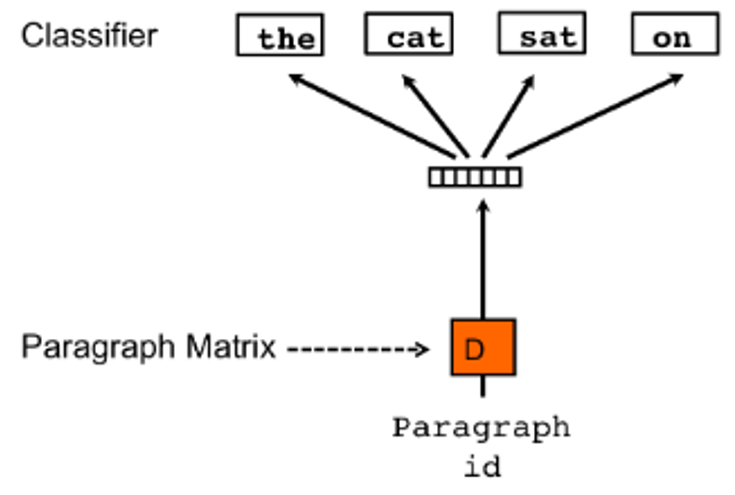

In [8]:
Image('images/DBOW.PNG')

In [16]:
if True:
    doc_vectorizer = doc2vec.Doc2Vec(

    dm = 0,            # PV-DBOW
    dbow_words = 1,    # w2v simultaneous with DBOW d2v / default 0
    window = 8,        # distance between the predicted word and context words 
    size = 300,        # vector size 
    sample = 1e-5,     # threshold for configuring
    min_count = 3,     # ignore with freq lower
    negative = 10,     # negative sampling / default 5

    seed = 2017,
    workers = 20,       # single cpu -> reproducible 
    alpha = 0.05,      # learning-rate
    min_alpha = 0.05   # min learning-rate

    )
    
    doc_vectorizer.build_vocab(tagged_train_docs)
    print(str(doc_vectorizer))
    
    for epoch in range(100):
        doc_vectorizer.train(tagged_train_docs, epochs = doc_vectorizer.iter ,
                             total_examples = doc_vectorizer.corpus_count )
        doc_vectorizer.alpha -= 0.002
        doc_vectorizer.min_alpha = doc_vectorizer.alpha
    
    print("Doc2Vec 학습 완료.")
# To save
doc_vectorizer.save('./D2V_model/Lpoint_C_Ver2.model')

Doc2Vec(dbow+w,d300,n10,w8,mc3,s1e-05,t20)


/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


Doc2Vec 학습 완료.


In [17]:
# To load
print("Load")
doc_vectorizer=doc2vec.Doc2Vec.load('./D2V_model/Lpoint_C_Ver2.model')

Load


> 학습된 모형에서 embedded vector를 가져오는 과정입니다.

In [18]:
print("Embedding")
train_item = [doc_vectorizer.infer_vector(doc.words) for doc in tagged_train_docs]
train_item_pd = pd.DataFrame(train_item)

test_item = [doc_vectorizer.infer_vector(doc.words) for doc in tagged_test_docs]
test_item_pd = pd.DataFrame(test_item)

Embedding


In [19]:
# 300차원으로 줄어든 Item들의 기술통계량
train_item_pd.describe()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
count,94785.000000,94785.000000,94785.000000,94785.000000,94785.000000,94785.000000,94785.000000,94785.000000,94785.000000,94785.000000,...,94785.000000,94785.000000,94785.000000,94785.000000,94785.000000,94785.000000,94785.000000,94785.000000,94785.000000,94785.000000
mean,-0.084141,-0.043109,0.137758,-0.167927,-0.039850,0.260571,-0.067787,-0.142020,0.139742,0.049893,...,0.286041,-0.089162,-0.067196,-0.073959,0.246272,-0.109025,-0.079358,0.004057,0.486809,-0.067619
std,0.093624,0.061594,0.135430,0.161226,0.069060,0.241306,0.082931,0.137855,0.135059,0.064963,...,0.266508,0.095648,0.078788,0.084776,0.230642,0.114236,0.090469,0.052515,0.448460,0.079985
min,-0.445283,-0.349572,-0.174116,-0.618441,-0.373054,-0.024929,-0.460500,-0.555858,-0.058721,-0.180712,...,-0.078955,-0.425543,-0.407422,-0.434611,-0.056162,-0.500419,-0.480335,-0.286024,-0.163947,-0.380197
25%,-0.162374,-0.085755,0.000137,-0.313725,-0.084589,0.000139,-0.132238,-0.265158,0.000326,-0.000059,...,0.000139,-0.170795,-0.129621,-0.139838,0.000096,-0.208891,-0.151841,-0.001717,0.000160,-0.131695
50%,-0.055603,-0.001595,0.149463,-0.199624,-0.001335,0.359199,-0.024314,-0.162992,0.162269,0.009065,...,0.383640,-0.068759,-0.033392,-0.043387,0.323130,-0.093063,-0.047205,0.000031,0.664846,-0.031694
75%,-0.000128,0.000343,0.260469,-0.000229,0.000552,0.484387,0.000026,-0.000096,0.260552,0.097529,...,0.534073,-0.000152,-0.000120,-0.000019,0.460643,-0.000123,0.000164,0.016066,0.915132,0.000051
max,0.210472,0.210942,0.531739,0.062064,0.335236,0.834991,0.191468,0.088095,0.527515,0.367239,...,0.927993,0.132477,0.177213,0.116735,0.806264,0.349208,0.173401,0.340319,1.412269,0.193146


> Train 데이터를 이용해서 고객별 session 을 Doc2Vec 으로 학습하였습니다.  
884개의 Item을 300 차원으로 embedding하여 각 column들이 Items 의 특징을 가지게 되었습니다.

---

## 3. Item Category

다시한번 예시 고객을 살펴보면, ID:1 고객이 __일반계란과 가공우유__ 또는 __일반계란과 일반두유__를 같이 구매할 가능성은 어떻게 될지 생각해보겠습니다.

고객/상품 | 상 품 종 류 가 .... 900개 정도
----------|:-------------------------------------
ID:1      | 일반계란 가공우유 일반두유 ...  

이러한 가능성을 구하는 것은 Liear model에서  __교차 특성__을 통해 실현이 가능합니다.  
이 교차 특성은 두 상품의 이진법(0, 1) 원소들의 __AND__ 방식으로 구현할 수 있습니다.  

하지만 이러한 방식이 너무 특별한 경우에 국한되었다고 생각될 수 있습니다.  

다른 상품들에 대해서도 일반화를 시키려면 문제가 있습니다. 이러한 문제는 각 상품의 상위 카테고리와 같은 덜 구체적인 값들을 사용하면 해결할 수 있습니다.

In [21]:
train_Segment.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Item Category는 각 아이템들의 상위 카테고리를 뜻합니다.  
예를들어 __일반계란__은 __X3__카테고리에 속합니다.  
이렇게 고객들이 해당 카테고리의 상품을 하나라도 구매했다면 해당 원소는 1로 표시됩니다.  

## Crossed Column

> **Wide**모델에서 feature들간의 **교호작용**을 주고 싶을 때 쓸 수 있음. <br>
> 여기선 **Segment** 2개간의 모든 **교호작용**을 추가함. <br>
> $_{17} C_2$ = 136개의 새로운 파생변수 생성

In [22]:
def cross_columns(data, cross_colnames):
    del_col = data.columns
    for i in cross_colnames:
        tmp = 0
        for j in i:
            tmp += 1
            if tmp == 1:
                cross_data = data[j]
                columns = j
            else:
                cross_data = cross_data + data[j]
                columns = columns + "+" + j
        data[columns] = cross_data
        
    data.drop(del_col, inplace=True, axis=1)
        
    return data

In [23]:
cross_col = [[train_Segment.columns[i], train_Segment.columns[i + j + 1]]
        for i in range(16) for j in range(16-i)]
print(cross_col)

[['X1', 'X2'], ['X1', 'X3'], ['X1', 'X4'], ['X1', 'X5'], ['X1', 'X6'], ['X1', 'X7'], ['X1', 'X8'], ['X1', 'X9'], ['X1', 'X10'], ['X1', 'X11'], ['X1', 'X12'], ['X1', 'X13'], ['X1', 'X14'], ['X1', 'X15'], ['X1', 'X16'], ['X1', 'X17'], ['X2', 'X3'], ['X2', 'X4'], ['X2', 'X5'], ['X2', 'X6'], ['X2', 'X7'], ['X2', 'X8'], ['X2', 'X9'], ['X2', 'X10'], ['X2', 'X11'], ['X2', 'X12'], ['X2', 'X13'], ['X2', 'X14'], ['X2', 'X15'], ['X2', 'X16'], ['X2', 'X17'], ['X3', 'X4'], ['X3', 'X5'], ['X3', 'X6'], ['X3', 'X7'], ['X3', 'X8'], ['X3', 'X9'], ['X3', 'X10'], ['X3', 'X11'], ['X3', 'X12'], ['X3', 'X13'], ['X3', 'X14'], ['X3', 'X15'], ['X3', 'X16'], ['X3', 'X17'], ['X4', 'X5'], ['X4', 'X6'], ['X4', 'X7'], ['X4', 'X8'], ['X4', 'X9'], ['X4', 'X10'], ['X4', 'X11'], ['X4', 'X12'], ['X4', 'X13'], ['X4', 'X14'], ['X4', 'X15'], ['X4', 'X16'], ['X4', 'X17'], ['X5', 'X6'], ['X5', 'X7'], ['X5', 'X8'], ['X5', 'X9'], ['X5', 'X10'], ['X5', 'X11'], ['X5', 'X12'], ['X5', 'X13'], ['X5', 'X14'], ['X5', 'X15'], ['X5', 'X

In [24]:
train_Segment_ = cp.deepcopy(train_Segment)
test_Segment_ = cp.deepcopy(test_Segment)
train_Segment_str = train_Segment_.astype(str)
test_Segment_str = test_Segment_.astype(str)

In [25]:
train_Segment_str.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
Segment = pd.concat([train_Segment_str, test_Segment_str], axis=0)
print(Segment.shape)
Segment.head()

(108700, 17)


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
print(cross_col)

[['X1', 'X2'], ['X1', 'X3'], ['X1', 'X4'], ['X1', 'X5'], ['X1', 'X6'], ['X1', 'X7'], ['X1', 'X8'], ['X1', 'X9'], ['X1', 'X10'], ['X1', 'X11'], ['X1', 'X12'], ['X1', 'X13'], ['X1', 'X14'], ['X1', 'X15'], ['X1', 'X16'], ['X1', 'X17'], ['X2', 'X3'], ['X2', 'X4'], ['X2', 'X5'], ['X2', 'X6'], ['X2', 'X7'], ['X2', 'X8'], ['X2', 'X9'], ['X2', 'X10'], ['X2', 'X11'], ['X2', 'X12'], ['X2', 'X13'], ['X2', 'X14'], ['X2', 'X15'], ['X2', 'X16'], ['X2', 'X17'], ['X3', 'X4'], ['X3', 'X5'], ['X3', 'X6'], ['X3', 'X7'], ['X3', 'X8'], ['X3', 'X9'], ['X3', 'X10'], ['X3', 'X11'], ['X3', 'X12'], ['X3', 'X13'], ['X3', 'X14'], ['X3', 'X15'], ['X3', 'X16'], ['X3', 'X17'], ['X4', 'X5'], ['X4', 'X6'], ['X4', 'X7'], ['X4', 'X8'], ['X4', 'X9'], ['X4', 'X10'], ['X4', 'X11'], ['X4', 'X12'], ['X4', 'X13'], ['X4', 'X14'], ['X4', 'X15'], ['X4', 'X16'], ['X4', 'X17'], ['X5', 'X6'], ['X5', 'X7'], ['X5', 'X8'], ['X5', 'X9'], ['X5', 'X10'], ['X5', 'X11'], ['X5', 'X12'], ['X5', 'X13'], ['X5', 'X14'], ['X5', 'X15'], ['X5', 'X

In [28]:
train_Segment_cross = cross_columns(train_Segment_str, cross_col)
test_Segment_cross = cross_columns(test_Segment_str, cross_col)

In [29]:
train_Segment_cross.head()

,X1+X2,X1+X3,X1+X4,X1+X5,X1+X6,X1+X7,X1+X8,X1+X9,X1+X10,X1+X11,...,X13+X14,X13+X15,X13+X16,X13+X17,X14+X15,X14+X16,X14+X17,X15+X16,X15+X17,X16+X17
0,0.00.0,0.01.0,0.00.0,0.00.0,0.00.0,0.01.0,0.00.0,0.00.0,0.00.0,0.01.0,...,0.00.0,0.00.0,0.00.0,0.01.0,0.00.0,0.00.0,0.01.0,0.00.0,0.01.0,0.01.0
1,0.00.0,0.00.0,0.00.0,0.00.0,0.01.0,0.00.0,0.00.0,0.00.0,0.00.0,0.01.0,...,1.00.0,1.01.0,1.01.0,1.01.0,0.01.0,0.01.0,0.01.0,1.01.0,1.01.0,1.01.0
2,0.00.0,0.01.0,0.00.0,0.01.0,0.00.0,0.00.0,0.00.0,0.00.0,0.00.0,0.00.0,...,0.00.0,0.00.0,0.00.0,0.00.0,0.00.0,0.00.0,0.00.0,0.00.0,0.00.0,0.00.0
3,0.00.0,0.00.0,0.00.0,0.00.0,0.00.0,0.01.0,0.00.0,0.00.0,0.00.0,0.00.0,...,0.00.0,0.01.0,0.00.0,0.00.0,0.01.0,0.00.0,0.00.0,1.00.0,1.00.0,0.00.0
4,1.00.0,1.00.0,1.00.0,1.00.0,1.00.0,1.00.0,1.00.0,1.00.0,1.00.0,1.00.0,...,0.00.0,0.00.0,0.00.0,0.00.0,0.00.0,0.00.0,0.00.0,0.00.0,0.00.0,0.00.0


> __AND__ 방식으로 계산된 상위 카테고리 데이터들은 __{T, T}, {T, F}, {F, T}, {F, F}__ 처럼 4개의 원소를 가지고 있으므로 모형의 Input 변수로 넣기위해 더미화 합니다.

In [36]:
train_Segment_cross_d = pd.get_dummies(train_Segment_cross)
test_Segment_cross_d = pd.get_dummies(test_Segment_cross)
train_Segment_cross_d.head()

,X1+X2_0.00.0,X1+X2_0.01.0,X1+X2_1.00.0,X1+X2_1.01.0,X1+X3_0.00.0,X1+X3_0.01.0,X1+X3_1.00.0,X1+X3_1.01.0,X1+X4_0.00.0,X1+X4_0.01.0,...,X15+X16_1.00.0,X15+X16_1.01.0,X15+X17_0.00.0,X15+X17_0.01.0,X15+X17_1.00.0,X15+X17_1.01.0,X16+X17_0.00.0,X16+X17_0.01.0,X16+X17_1.00.0,X16+X17_1.01.0
0,1,0,0,0,0,1,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0
1,1,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,1
2,1,0,0,0,0,1,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0
3,1,0,0,0,1,0,0,0,1,0,...,1,0,0,0,1,0,1,0,0,0
4,0,0,1,0,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,0


## High API를 사용할 때는 지정만 해주면 됩니다.

```
Seg = [`X1` , `X2` , `X3` , ... , `X17`]
cross_col = [[Seg[i], Seg[i + j + 1]]
        for i in range(16) for j in range(16-i)]
Cross_Columns = []
for i , j in cross_col :
    id1 , id2 = Seg_dict[i] , Seg_dict[j]
    cross_tf = tf.contrib.layers.crossed_column\
    ([Categorical_base[id1], Categorical_base[id2]],
     hash_bucket_size=int(1e4))
    Cross_Columns.append(cross_tf)
```

---

## 4. User Features

Deep Model 쪽에 들어갈 고객의 특성데이터는 다음과 같습니다.

1. 범주형 데이터 (성별, 연령대, 거주지역)
2. 연속형 데이터 (맴버십 가입여부, 경쟁사 이용횟수)

>  범주형은 임베딩을 해서 넣고, 실수형은 그대로 들어갑니다.


```
High API에서 사용할 때,
범주형 데이터 (성별, 연령대, 거주지역)
embed_col = []
for idx , i in enumerate(Categorical_col) :
    key = Categorical_base2[idx]
    k = 8
    dim = int( np.ceil( np.sqrt(Input[i].nunique()) ) ) * k
    emb = tf.contrib.layers.embedding_column(key , dimension=dim)
    embed_col.append(emb)

```

In [15]:
train_categorical.head()

NameError: name 'train_categorical' is not defined

In [31]:
train_continuous.head()

,다둥이,더영,롭스,하이마트,A01,A02,B01,B02,C01,C02,C03,D01,D02
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
train_user_feartures = pd.concat([train_continuous, train_categorical], axis=1)
test_user_feartures = pd.concat([test_continuous, test_categorical], axis=1)

In [33]:
train_user_feartures.head()

,다둥이,더영,롭스,하이마트,A01,A02,B01,B02,C01,C02,C03,D01,D02,성별,연령대,A거주지역
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,F,50세~54세,A24
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,F,60세이상,A100
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,F,35세~39세,A210
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,F,35세~39세,A210
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,F,50세~54세,A100


In [34]:
train_user_feartures[["연령대", "A거주지역", "성별"]].head()

,연령대,A거주지역,성별
0,50세~54세,A24,F
1,60세이상,A100,F
2,35세~39세,A210,F
3,35세~39세,A210,F
4,50세~54세,A100,F


---

## High API를 사용 할 때는 지정만 해주면 가능합니다.
```
[ tf.contrib.layers.sparse_column_with_keys\
 ( Cat , keys = Input[Cat].unique().tolist() ) for Cat in Categorical_col ]
 ```

## 5. Data Concatenate

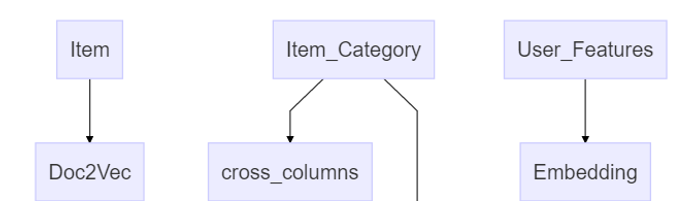

In [5]:
Image('images/Architecture_pre.PNG')

지금까지 진행한 전처리작업은 위 그림과 같습니다.  
이제 따로따로 처리하였던 데이터들을 하나로 합쳐 Input 데이터 형식처럼 만들어 주어야 합니다.  


### Wide 에 들어갈 Input 형식입니다.

---
Wide 모델(Memorization) :
* 기존에 있었던 정보만을 바탕으로 추천함. <br>
* 단점 : <br>
항상 같은 것만 추천하고, 관련된 다른 제품에 대해서 추천을 안하게 됩니다. <br>
**예)** 과일이라 검색하고, 바나나를 산 기록이 많을 경우에, 과일이라 검색할 경우 항상 바나나를 추천하게 됩니다.

In [37]:
Wide_data = pd.concat([train_item_pd, train_Segment_cross_d], axis=1)
Wide_data_test = pd.concat([test_item_pd, test_Segment_cross_d], axis=1)

print(Wide_data.shape)
print(Wide_data_test.shape)

Wide_data.head()

(94785, 844)
(13915, 844)


,0,1,2,3,4,5,6,7,8,9,...,X15+X16_1.00.0,X15+X16_1.01.0,X15+X17_0.00.0,X15+X17_0.01.0,X15+X17_1.00.0,X15+X17_1.01.0,X16+X17_0.00.0,X16+X17_0.01.0,X16+X17_1.00.0,X16+X17_1.01.0
0,-0.000049,0.001423,-0.000471,0.000744,0.001612,0.000709,0.000148,-0.001093,-0.001145,0.000475,...,0,0,0,1,0,0,0,1,0,0
1,-0.216750,-0.113623,0.317689,-0.423609,-0.101565,0.505012,-0.020925,-0.351648,0.174870,0.157200,...,0,1,0,0,0,1,0,0,0,1
2,-0.195704,-0.116848,0.163904,-0.218513,-0.110189,0.598278,-0.231470,-0.210153,0.308999,0.126840,...,0,0,1,0,0,0,1,0,0,0
3,-0.001624,0.000312,-0.000389,0.000081,0.000951,0.000662,-0.000984,0.000419,-0.000304,0.001451,...,1,0,0,0,1,0,1,0,0,0
4,-0.032823,-0.090666,0.096372,-0.062713,0.042202,0.247300,-0.080214,-0.182904,0.259639,0.189134,...,0,0,1,0,0,0,1,0,0,0


### Deep 에 들어갈 Input 형식입니다.
---

Deep 모델(Generalization)
* 일반화시켜서 분류한 다음, 추천해주는 방식
* 단점 : <br>
일반화가 잘 되지 않을 시 잘못된 추천을 해줄 수 있습니다.<br>
**예)**  양념치킨을 검색했는데, 치킨이라는 일반화범주에 맞춰서, 치킨마요덮밥을 추천해줄 수 있습니다.  

In [40]:
Deep_data = pd.concat([train_item_pd, train_Segment, train_user_feartures], axis=1)
Deep_data_test = pd.concat([test_item_pd, test_Segment, test_user_feartures], axis=1)

print(Deep_data.shape)
print(Deep_data_test.shape)

Deep_data.head()

(94785, 333)
(13915, 333)


,0,1,2,3,4,5,6,7,8,9,...,B01,B02,C01,C02,C03,D01,D02,성별,연령대,A거주지역
0,-0.000049,0.001423,-0.000471,0.000744,0.001612,0.000709,0.000148,-0.001093,-0.001145,0.000475,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,F,50세~54세,A24
1,-0.216750,-0.113623,0.317689,-0.423609,-0.101565,0.505012,-0.020925,-0.351648,0.174870,0.157200,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,F,60세이상,A100
2,-0.195704,-0.116848,0.163904,-0.218513,-0.110189,0.598278,-0.231470,-0.210153,0.308999,0.126840,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,F,35세~39세,A210
3,-0.001624,0.000312,-0.000389,0.000081,0.000951,0.000662,-0.000984,0.000419,-0.000304,0.001451,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,F,35세~39세,A210
4,-0.032823,-0.090666,0.096372,-0.062713,0.042202,0.247300,-0.080214,-0.182904,0.259639,0.189134,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,F,50세~54세,A100


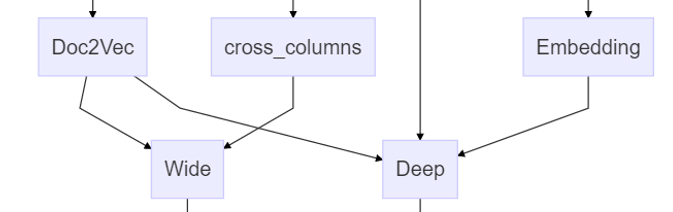

In [4]:
Image('images/Architecture_sum.PNG')

---

위에서 말한 **Wide** 모델의 단점과 **Deep** 모델의 단점을 해결하기위해 WideDeep 모델을 구글이 개발했습니다. <br>
overfit과 underfit 사이에서 적절히 안배하여, 좋은 추천을 하게 합니다.

* 플레이스토어 적용한 결과, 큰 효과를 얻었다고 합니다.

이렇게 모형에 Input 으로 집어넣을 데이터들이 만들어졌습니다.  
나중에 재사용 하기 위해 최종 데이터를 저장합니다.

>  Column 한글 이름을 scope name으로 사용 불가능하므로 변경해야 합니다.
* tensorflow에서 scope name의 regular expression 정해놓음
* scope란? tensorflow graph를 그릴 때 설정해주는 이름.

## Data Concatenate

> Item2Vec + User Feature + Segment Info

In [16]:
name ='A거주지역'
_VALID_SCOPE_NAME_REGEX = re.compile("^[A-Za-z0-9_.\\-/]*$")
if not _VALID_SCOPE_NAME_REGEX.match(name):
    raise ValueError("'%s' is not a valid scope name" % name)

ValueError: 'A거주지역' is not a valid scope name

In [41]:
def preprocessing( D2V , train_user_feartures , Segment_data ) :
    D2V.columns = "D2V_" +  D2V.columns.astype(str) 
    Continuous_col = D2V.columns.tolist()
    Seg = Segment_data.columns.tolist()
    Cat_col = ["Gender" , "AgeGroup" ,"A_residential_area"] 
    user_feature_col = train_user_feartures.columns.tolist()
    Num_col = ["dadungi" , "Deoyoung" ,"Robs", "himart"] +\
    [ i for i in user_feature_col if re.search("[A-D][0-9]{2}" , i) is not None ]
    train_user_feartures.columns = Num_col + Cat_col
    train_user_feartures = train_user_feartures[Cat_col + Num_col]
    merge_data = pd.concat([D2V , train_user_feartures , Segment_data] , axis = 1)
    merge_data[Continuous_col + Num_col] =\
    merge_data[Continuous_col + Num_col ].astype(float)
    merge_data[ Cat_col + Seg ] =\
    merge_data[ Cat_col + Seg ].astype(str)
    return merge_data

In [ ]:
train_data = preprocessing( train_item_pd , train_user_feartures , train_Segment )
test_data = preprocessing( test_item_pd , test_user_feartures , test_Segment )

In [89]:
test_data.to_csv("./Test_Data_ver2.csv" , index = False)

In [100]:
obj_col = train_data.select_dtypes("object").columns.tolist()

In [46]:
assert train_data.columns.tolist() == test_data.columns.tolist()

## Tensorflow High API를 사용하기 위해 전처리
 
> HIGH API에서는 Classifier를 활용하기 때문에 현재 유저별로 Item Category 된 자료를 onehot을 변경해주는 작업 필요

> 예를 들어, 한 ID에 2개의 Item이 있다면 2개의 row가 생기는 형태로 변경
* 인풋은 동일한 형태 
* 타겟은 각 Item

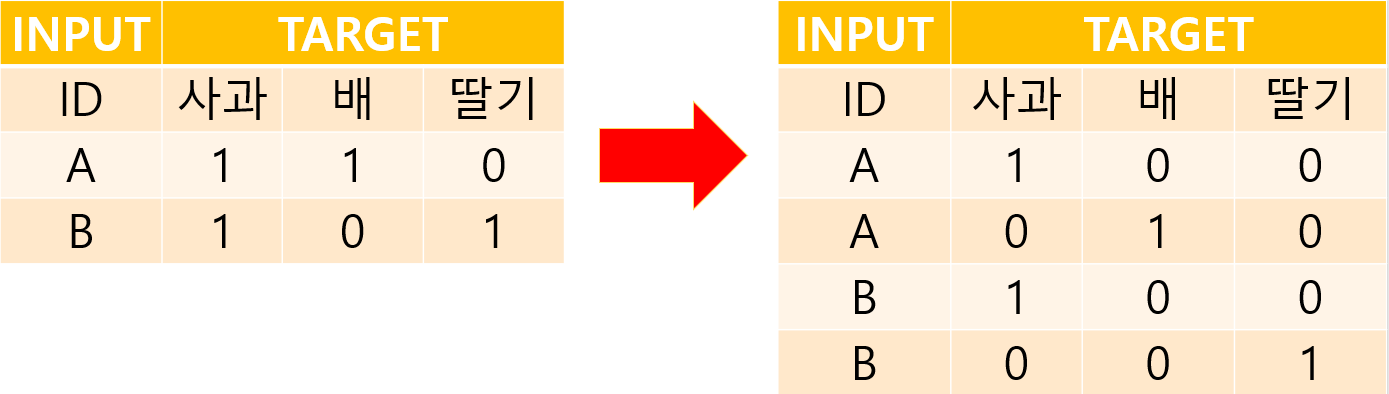

In [3]:
Image('images/Data_Preprocessing.PNG')

---

In [67]:
target_n = len(train_label.columns)
num_cores = 20 
def onehot(x) :
    total = np.array([], dtype=np.int64).reshape( 0,  target_n + 1 )
    for index ,  i in zip(x.index.values.tolist() , x.values) :
        which = np.where(i == 1 )[0]
        idx_info =np.array([  index  ] * len(which)).reshape(-1,1)
        mat = np.zeros(( len(which ) , target_n  ) )
        mat = np.concatenate([mat , idx_info ] , axis = 1)
        for idx , row in enumerate(mat) :
            row[which[idx]] = 1 
        total = np.concatenate([total, mat ])
    return total

def parallelize_array(df, func):
    df_split = np.array_split(df , num_cores)
    pool = Pool(num_cores)
    df = np.concatenate(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

def pandas_replicate(x) :
    total_df = pd.DataFrame([], columns = train_data.columns )
    for idx , df_row in x.iterrows() :
        total_df = total_df.append([df_row]*dict_[idx] ,ignore_index=True )
    return total_df

def parallelize_pandas(df, func):
    df_split = np.array_split(df , num_cores)
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

## 변경 후  
* **Train** : __94785 → 342551__ 
* Test는 학습시키는 대상이 아니므로, High API를 쓸때는 형태를 바꿔줄 필요가 없습니다.

In [64]:
start = time.time()
for idx , i in enumerate(np.split(train_label.index.values , 3)) :
    out = parallelize_array(train_label.iloc[i ,:] , onehot)
    #out = out.astype(float)
    np.save("Trans_{}_Result_ver2.npy".format(idx) , out)
    del out 
print("소요시간 : " , time.time() - start )    

소요시간 :  120.3619134426117


In [76]:
start = time.time()
for idx in np.arange(3) :
    print("Start : " , str(idx) )
    file_name = "Trans_{}_Result_ver2.npy".format(str(idx))
    first = np.load(file_name)
    list_ = pd.Series(first[:,-1]).astype(int).value_counts().sort_index()
    dict_ = dict(zip(list_.index.tolist() ,  list_.values.tolist()))
    output  = parallelize_pandas( 
        train_data.iloc[list(dict_.keys()) , : ] , pandas_replicate )
    output.to_csv("Trans_{}_Result_ver2.csv".format(idx) , index = False)
    del output
print("소요시간 : " , time.time() - start )       

Start :  0
Start :  1
Start :  2
소요시간 :  628.4774425029755


## Split한 데이터 다시 합쳐서 저장하기

In [86]:
start = time.time()
dir_ = os.listdir()
Input_dir = [ i for i in dir_ if re.search('^Trans([^"]+)_ver2.csv$' , i ) is not None ]
Input_dir.sort()
print(Input_dir)
Target_dir = [ i for i in dir_ if re.search('^Trans([^"]+)_ver2.npy$' , i ) is not None ]
Target_dir.sort()
print(Target_dir)
##
for idx , target in enumerate(Target_dir) :
    if idx == 0 :
        train_label = np.load(target)
    else :
        train_label = np.concatenate([train_label , np.load(target) ])
train_label = train_label[:, :-1]
##
Input = pd.DataFrame([])
for i in Input_dir :
    Input = pd.concat([Input , pd.read_csv(i)])
Input.reset_index(drop = True , inplace = True) 
for idx , target in enumerate(Target_dir) :
    if idx == 0 :
        train_label = np.load(target)
    else :
        train_label = np.concatenate([train_label , np.load(target) ])
train_label = train_label[:, :-1]
## argmax
target =  np.argmax( train_label , axis = 1).astype(int)
LABEL_COLUMN = "target"
Input[LABEL_COLUMN] = target
Input[obj_col] = Input[obj_col].astype(str)
Input.to_csv("Total_Data_ver2.csv", index = False)
print("소요시간 : " , time.time() - start )       

['Trans_0_Result_ver2.csv', 'Trans_1_Result_ver2.csv', 'Trans_2_Result_ver2.csv']
['Trans_0_Result_ver2.npy', 'Trans_1_Result_ver2.npy', 'Trans_2_Result_ver2.npy']
소요시간 :  329.4926950931549


> 사용할 데이터 처리가 완료되었습니다. <br>
이제 만든 데이터를 활용해 Wide Deep 모델에 적용하면 됩니다.